In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Define column names
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load datasets
train = pd.read_csv("KDDTrain+.txt", names=c_names)
test = pd.read_csv("KDDTest+.txt", names=c_names)

# Drop irrelevant column
train.drop("difficulty_degree", axis=1, inplace=True)
test.drop("difficulty_degree", axis=1, inplace=True)

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]
for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Convert labels to binary (1 = normal, 0 = attack)
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Split features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert each row into a text sequence
train_sequences = [" ".join(map(str, row)) for row in X_train]
test_sequences = [" ".join(map(str, row)) for row in X_test]


In [3]:
# Load Bloom tokenizer
model_name = "bigscience/bloom-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize data
train_encodings = tokenizer(train_sequences, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_sequences, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Convert labels to tensors
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], y_train)
test_dataset = torch.utils.data.TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], y_test)

# Create dataloaders
batch_size = 64  # Reduced for memory efficiency
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# Load smaller Bloom model
bloom_model = AutoModel.from_pretrained(model_name)

# Enable memory optimizations
bloom_model.gradient_checkpointing_enable()
bloom_model.to(torch.float16)  # Mixed-precision training for lower memory usage

# Define a classification model
class BloomIDSModel(nn.Module):
    def __init__(self, bloom_model):
        super(BloomIDSModel, self).__init__()
        self.bloom = bloom_model
        self.fc = nn.Linear(1024, 2)  # Adjusted for smaller Bloom model

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Disable gradient calculation for Bloom backbone
            outputs = self.bloom(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Extract CLS token
        return self.fc(pooled_output)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloomIDSModel(bloom_model).to(device)


In [5]:
# Clear GPU memory before training
torch.cuda.empty_cache()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

# Enable automatic mixed precision (AMP) to reduce memory usage
scaler = torch.cuda.amp.GradScaler()

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Enable mixed precision
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.4f}")


<ipython-input-5-a9a39d7a4c60>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-5-a9a39d7a4c60>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1, Loss: 2239.9540, Train Accuracy: 0.5142
Epoch 2, Loss: 1364.8397, Train Accuracy: 0.5220
Epoch 3, Loss: 1363.1739, Train Accuracy: 0.5199
Epoch 4, Loss: 1363.7328, Train Accuracy: 0.5185
Epoch 5, Loss: 1362.5016, Train Accuracy: 0.5202


In [6]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Put model in evaluation mode
model.eval()

# Initialize lists for true labels and predictions
y_pred = []
y_true = []

# Run inference on the test set
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids = input_ids.to(device).to(torch.long)  # Token IDs must be `long`
        attention_mask = attention_mask.to(device).to(torch.float16)  # Match model precision
        labels = labels.to(device)

        # Enable mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask)

        predictions = outputs.argmax(1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {test_acc:.4f}\n")

# Display classification report
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred, target_names=["Attack", "Normal"]))


<ipython-input-6-e328850a6ad8>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



✅ Test Accuracy: 0.5269


📊 Classification Report:
               precision    recall  f1-score   support

      Attack       0.55      0.92      0.69     12833
      Normal       0.03      0.00      0.01      9711

    accuracy                           0.53     22544
   macro avg       0.29      0.46      0.35     22544
weighted avg       0.33      0.53      0.40     22544



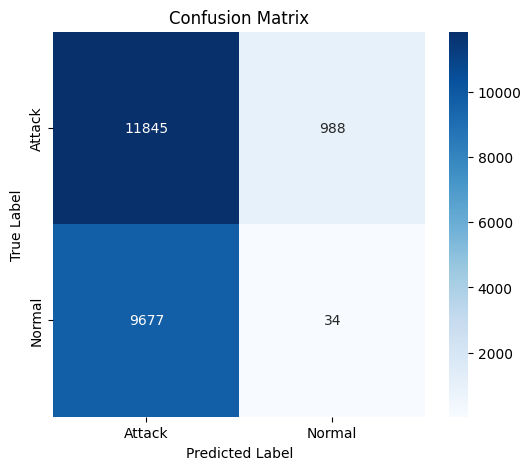

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("Bloom_Confusion-Matrix.png")  # Save the figure
plt.show()


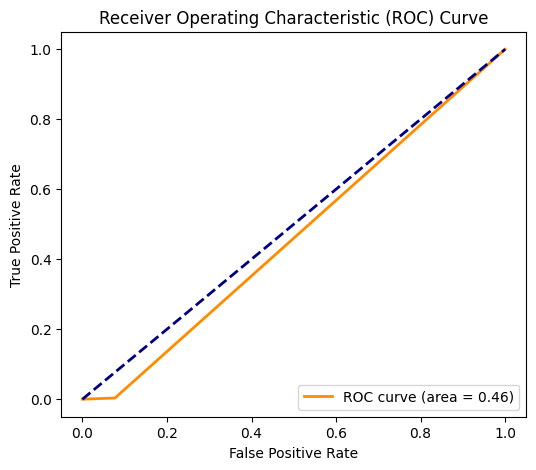

In [8]:
from sklearn.metrics import roc_curve, auc

# Convert labels to binary format
y_test_binarized = np.array(y_true)
y_pred_proba = np.array(y_pred)  # Since we used argmax, we treat it as direct class output

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("Bloom_ROC_Curve.png")  # Save the figure
plt.show()
